<a href="https://colab.research.google.com/github/sagar2582/Classification-And-Change-Analysis-of-the-SUNDARBANS/blob/main/Change_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import requires libraries

from osgeo import ogr, gdal, osr
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Input Raster and Vector Paths
#Image-2019
path_B5_2019= '/content/drive/My Drive/Colab Notebooks/Minor Project/2019/LC08_L1TP_138045_20190130_20190206_01_T1_B5.TIF'
path_B4_2019= '/content/drive/My Drive/Colab Notebooks/Minor Project/2019/LC08_L1TP_138045_20190130_20190206_01_T1_B4.TIF'

#Image-2017
path_B5_2017 = '/content/drive/My Drive/Colab Notebooks/Minor Project/2017/LC08_L1TP_138045_20170108_20170311_01_T1_B5.TIF'
path_B4_2017 = '/content/drive/My Drive/Colab Notebooks/Minor Project/2017/LC08_L1TP_138045_20170108_20170311_01_T1_B4.TIF'

In [ ]:
#Output Files
#Output NDVI Rasters 
path_NDVI_2019 = '/content/drive/My Drive/Colab Notebooks/Minor Project/NDVI2019.tif'
path_NDVI_2017 = '/content/drive/My Drive/Colab Notebooks/Minor Project/NDVI2017.tif'
path_NDVIChange_19_17 = '/content/drive/My Drive/Colab Notebooks/Minor Project/NDVIChange_19_17.tif'

#NDVI Contours
contours_NDVIChange_19_17 = '/content/drive/My Drive/Colab Notebooks/Minor Project/NDVIChange_19_17.shp'

Open the Landsat image bands with GDAL:

In this part we open the red (Band 4) and near infrared NIR (Band 5) with commands of the GDAL library and then we read the images as matrix arrays with float numbers of 32 bits.

In [ ]:
#Open raster bands
B5_2019 = gdal.Open(path_B5_2019)
B4_2019 = gdal.Open(path_B4_2019)
B5_2017 = gdal.Open(path_B5_2017)
B4_2017 = gdal.Open(path_B4_2017)

In [ ]:
#Read bands as matrix arrays
B52019_Data = B5_2019.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42019_Data = B4_2019.GetRasterBand(1).ReadAsArray().astype(np.float32)
B52017_Data = B5_2017.GetRasterBand(1).ReadAsArray().astype(np.float32)
B42017_Data = B4_2017.GetRasterBand(1).ReadAsArray().astype(np.float32)

Compare matrix sizes and geotransformation parameters :
 
The operation in between Landsat 8 bands depends that the resolution, size, src, and geotransformation parameters are the same for both images. In case these caracteristics do not coincide a warp, reproyection, scale or any other geospatial process would be necessary.

In [ ]:
#B5_2017.GetProjection()[:80] = PROJCS["WGS 84 / UTM zone 45",GEOGCS["WGS 84",DATUM["WGS84",ELLIPSOID["WGS 84"] 
#B5_2019.GetProjection()[:80] = PROJCS["WGS 84 / UTM zone 45",GEOGCS["WGS 84",DATUM["WGS84",ELLIPSOID["WGS 84"] 

In [ ]:
print(B5_2017.GetProjection()[:80])
print(B5_2019.GetProjection()[:80])
if B5_2017.GetProjection()[:80]==B5_2019.GetProjection()[:80]: print('SRC OK')

PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84
SRC OK


In [ ]:
print(B52017_Data.shape)
print(B52019_Data.shape)
if B52017_Data.shape==B52019_Data.shape: print('Array Size OK')

(7721, 7561)
(7721, 7561)
Array Size OK


In [ ]:
print(B5_2017.GetGeoTransform())
print(B5_2019.GetGeoTransform())
if B5_2017.GetGeoTransform()==B5_2019.GetGeoTransform(): print('Geotransformation OK')

(542385.0, 30.0, 0.0, 2512515.0, 0.0, -30.0)
(545385.0, 30.0, 0.0, 2512515.0, 0.0, -30.0)


Get geotransformation parameters

In [ ]:
geotransform = B5_2017.GetGeoTransform()

originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
cols =  B5_2017.RasterXSize
rows =  B5_2017.RasterYSize

In [ ]:
projection = B5_2017.GetProjection()
projection

'PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]'

In [ ]:
finalX = originX + pixelWidth * cols
originY = finalY + pixelHeight * rows

Compute the NDVI and store them as a different file

In [ ]:
ndvi2017 = np.divide(B52017_Data - B42017_Data, B52017_Data+ B42017_Data,where=(B52017_Data - B42017_Data)!=0)
ndvi2017[ndvi2017 == 0] = -999

In [ ]:
ndvi2019 = np.divide(B52019_Data - B42019_Data, B52019_Data+ B42019_Data,where=(B52019_Data - B42019_Data)!=0)
ndvi2019[ndvi2019 == 0] = -999

In [ ]:
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None

In [ ]:
saveRaster(ndvi2017,path_NDVI_2017,cols,rows,projection)

saveRaster(ndvi2019,path_NDVI_2019,cols,rows,projection)

Plot NDVI Images

In [ ]:
extentArray = [originX,finalX,originY,finalY]
def plotNDVI(ndviImage,extentArray,vmin,cmap):
    ndvi = gdal.Open(ndviImage)
    ds2019 = ndvi.ReadAsArray()
    plt.figure(figsize=(20,15))
    im = plt.imshow(ds2019, vmin=vmin, cmap=cmap, extent=extentArray)#
    plt.colorbar(im, fraction=0.015)
    plt.xlabel('Este')
    plt.ylabel('Norte')
    plt.show()

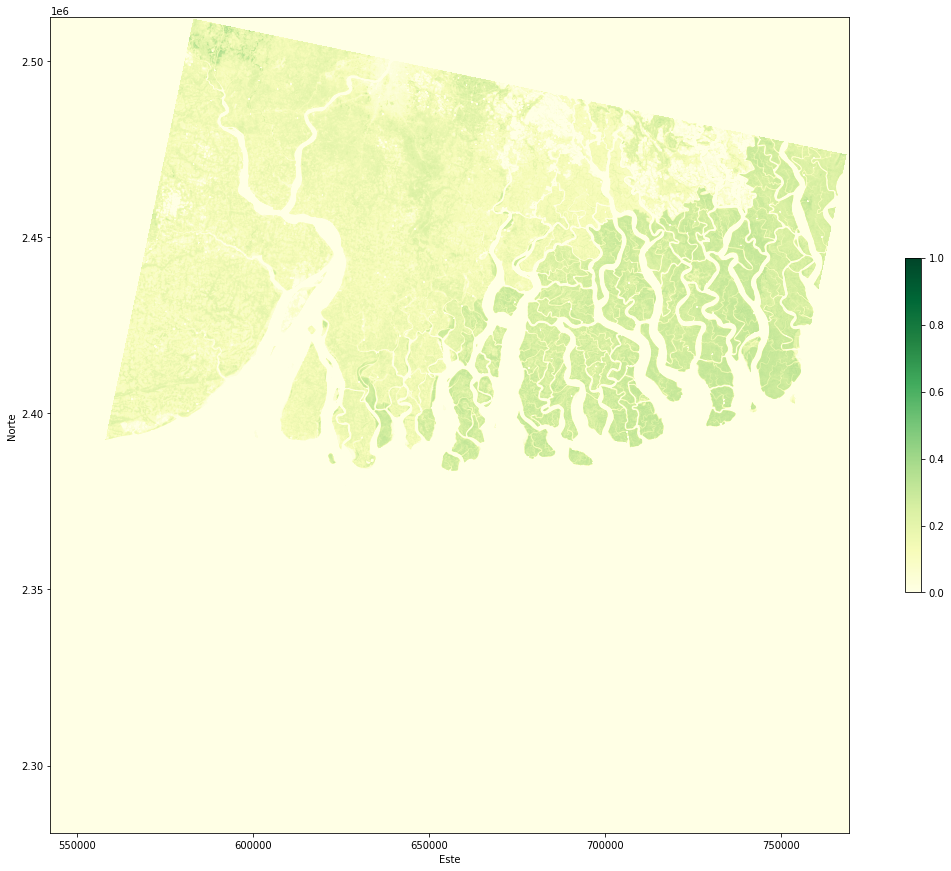

In [ ]:
plotNDVI(path_NDVI_2017,extentArray,0,'YlGn')

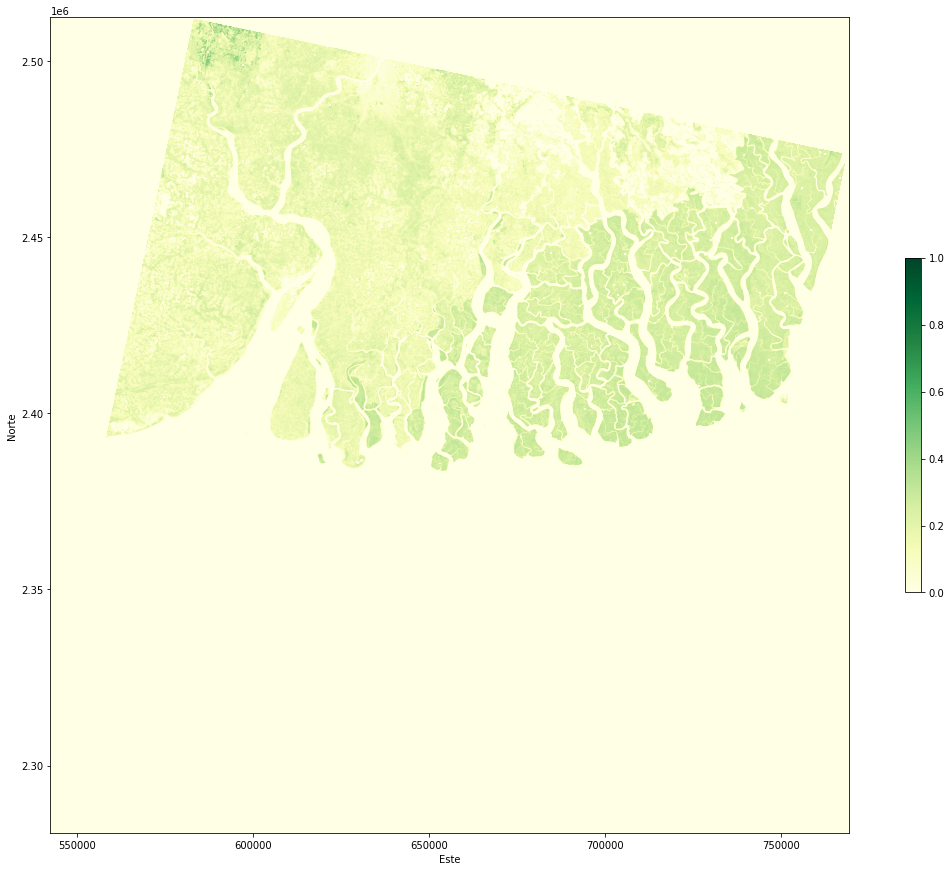

In [ ]:
plotNDVI(path_NDVI_2019,extentArray,0,'YlGn')

Create a land cover change image


In [ ]:
ndviChange = ndvi2019-ndvi2017
ndviChange = np.where((ndvi2017>-999) & (ndvi2019>-999),ndviChange,-999)
ndviChange

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

In [ ]:
saveRaster(ndviChange,path_NDVIChange_19_17,cols,rows,projection)

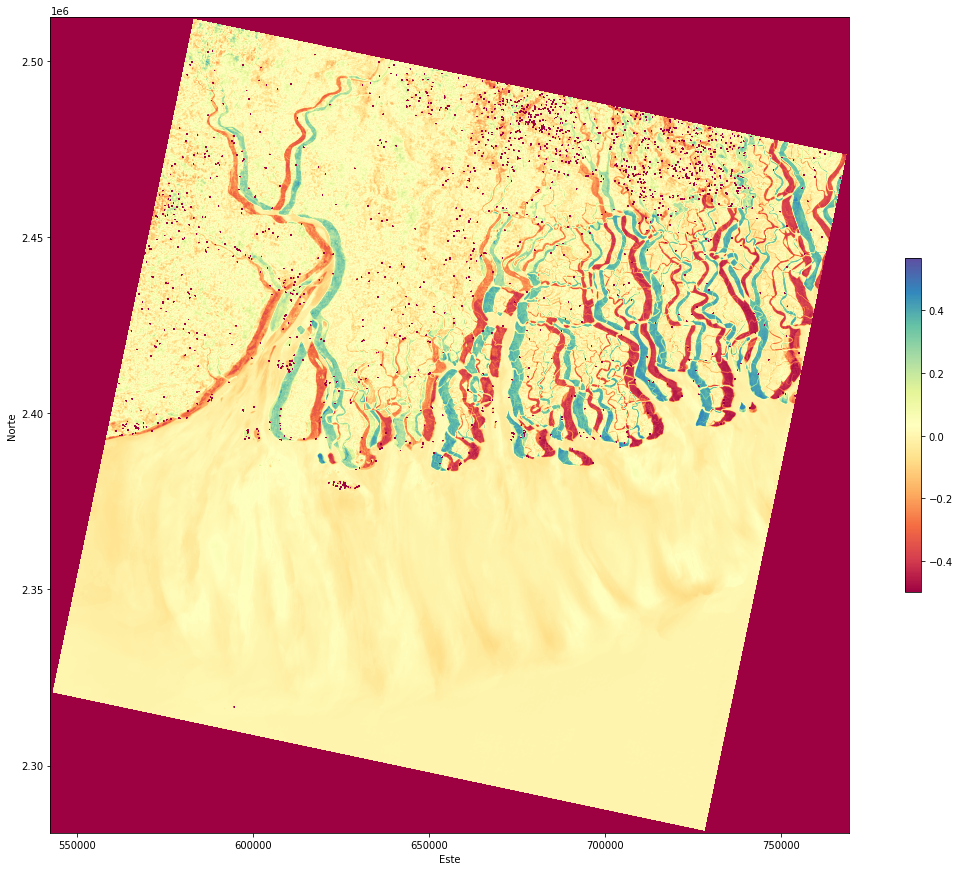

In [ ]:
plotNDVI(path_NDVIChange_19_17,extentArray,-0.5,'Spectral')

Create Contourlines

In [ ]:
Dataset_ndvi = gdal.Open(path_NDVIChange_19_17)#path_NDVI_2017
ndvi_raster = Dataset_ndvi.GetRasterBand(1)

ogr_ds = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contours_NDVIChange_19_17)

prj=Dataset_ndvi.GetProjectionRef()#GetProjection()

srs = osr.SpatialReference(wkt=prj)#
#srs.ImportFromProj4(prj)

contour_shp = ogr_ds.CreateLayer('contour', srs)
field_defn = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_shp.CreateField(field_defn)
field_defn = ogr.FieldDefn("ndviChange", ogr.OFTReal)
contour_shp.CreateField(field_defn)
#Generate Contourlines
gdal.ContourGenerate(ndvi_raster, 0.1, 0, [], 1, -999, contour_shp, 0, 1)
ogr_ds = None